In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import HDBSCAN
import time
from tqdm import tqdm

In [2]:
questions = np.load(os.path.join(Path.cwd().parent,'data', "question_embeddings.npy"))

In [5]:
questions

array([[ 0.00135186, -0.01567405, -0.00407692, ..., -0.00051256,
        -0.01407612,  0.03170738],
       [ 0.00947397, -0.01458311, -0.01913991, ...,  0.01237694,
         0.0026381 ,  0.00367426],
       [-0.00196639, -0.02462533, -0.02752738, ..., -0.02915011,
        -0.01131252,  0.00531276],
       ...,
       [ 0.01124157, -0.00401997, -0.00109108, ...,  0.01684531,
        -0.01445533, -0.01146719],
       [ 0.00541865, -0.008558  ,  0.02181992, ...,  0.04608485,
        -0.00460435,  0.00354097],
       [-0.01140477, -0.00173025,  0.00033578, ..., -0.00541803,
         0.00156366,  0.03781059]], shape=(99992, 4096))

In [6]:
question_subset = questions[:30_000]
question_subset

array([[ 0.00135186, -0.01567405, -0.00407692, ..., -0.00051256,
        -0.01407612,  0.03170738],
       [ 0.00947397, -0.01458311, -0.01913991, ...,  0.01237694,
         0.0026381 ,  0.00367426],
       [-0.00196639, -0.02462533, -0.02752738, ..., -0.02915011,
        -0.01131252,  0.00531276],
       ...,
       [ 0.0088692 , -0.02893733, -0.01126055, ..., -0.01242154,
        -0.01010187,  0.0122135 ],
       [ 0.03130452, -0.01181498, -0.02598695, ..., -0.00792509,
         0.01304766,  0.01627016],
       [-0.00872451, -0.01761353,  0.00159271, ..., -0.01553957,
        -0.0140381 ,  0.00658838]], shape=(30000, 4096))

In [7]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

In [8]:
questions_normalized = normalize(question_subset, 'l2')
questions_normalized

array([[ 0.00135186, -0.01567404, -0.00407692, ..., -0.00051256,
        -0.01407612,  0.03170737],
       [ 0.00947397, -0.01458311, -0.01913992, ...,  0.01237694,
         0.0026381 ,  0.00367427],
       [-0.00196639, -0.02462532, -0.02752737, ..., -0.02915011,
        -0.01131252,  0.00531276],
       ...,
       [ 0.0088692 , -0.02893733, -0.01126055, ..., -0.01242154,
        -0.01010187,  0.0122135 ],
       [ 0.03130451, -0.01181498, -0.02598695, ..., -0.00792509,
         0.01304766,  0.01627016],
       [-0.00872451, -0.01761353,  0.00159271, ..., -0.01553958,
        -0.0140381 ,  0.00658838]], shape=(30000, 4096))

In [9]:
nbrs = NearestNeighbors(n_neighbors=6, metric='cosine').fit(questions_normalized)
dists, inds = nbrs.kneighbors(questions_normalized)

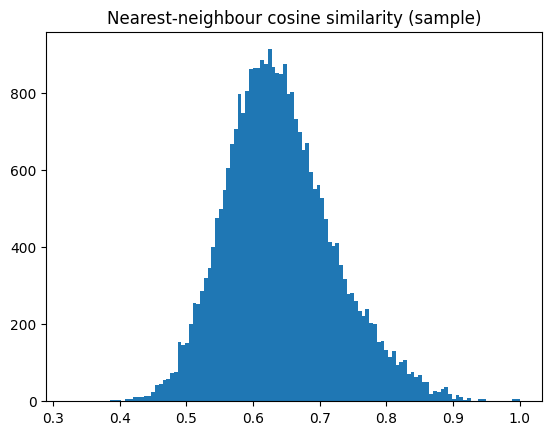

In [10]:
nn_cosines = 1 - dists[:,1]   # convert cosine distance -> cosine similarity
plt.hist(nn_cosines, bins=120)
plt.title("Nearest-neighbour cosine similarity (sample)")
plt.show()


In [11]:
np.std(nn_cosines)

np.float64(0.08171241906265375)

In [20]:
from umap import UMAP

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
from sklearn.metrics import calinski_harabasz_score,silhouette_score
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=1024, svd_solver='randomized')
X_pca = pca.fit_transform(questions_normalized)
um = UMAP(n_components=5, n_neighbors=15, min_dist=0.0, metric='cosine', random_state=42)
tags_umapped = um.fit_transform(X_pca)

/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
tags_umapped

array([[5.657068  , 6.739372  , 1.4715964 , 0.97866416, 6.3740745 ],
       [7.30392   , 6.6302214 , 3.5687063 , 2.074182  , 5.5291977 ],
       [3.5490248 , 5.75157   , 2.8280056 , 2.2697527 , 5.7315526 ],
       ...,
       [6.6043215 , 7.2426214 , 2.1936686 , 1.7467015 , 5.9296627 ],
       [8.743119  , 7.730148  , 3.0965874 , 3.969064  , 6.700023  ],
       [8.242246  , 6.140573  , 1.3171232 , 1.826248  , 4.961568  ]],
      shape=(30000, 5), dtype=float32)

In [58]:
hdbscan_model = HDBSCAN(min_cluster_size=15,
    min_samples=5,                   
    metric='euclidean',
    cluster_selection_method='eom',
    cluster_selection_epsilon=0.16
)

In [59]:
hdbscan_model.fit(tags_umapped)
calinski_harabasz_score(tags_umapped, hdbscan_model.labels_)

787.0186767578125

<Axes: ylabel='Count'>

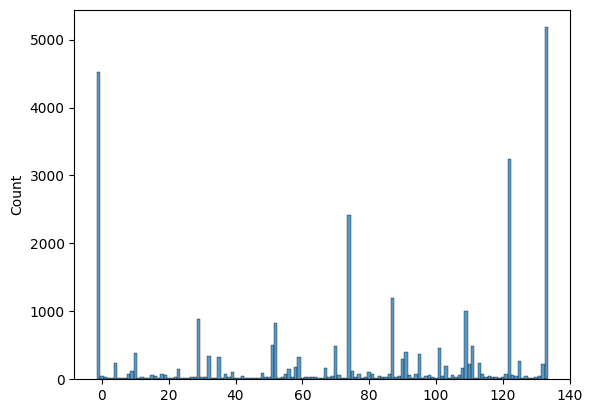

In [60]:
sns.histplot(data=hdbscan_model.labels_, discrete=True)

---

In [66]:
import optuna
from collections import Counter, defaultdict
from sklearn.metrics import normalized_mutual_info_score


In [ ]:
def cluster_weighted_purity(labels, tags_list, noise_label=-1, top_tag_only=True):
    """
    Weighted cluster purity:
    - tags_list: list of lists (tags per sample).
    - For multi-tag questions we take the first/top tag if top_tag_only=True.
    - Returns weighted average purity in [0,1].
    """
    cluster_to_tag_counts = defaultdict(Counter)
    cluster_sizes = defaultdict(int)
    for i, lbl in enumerate(labels):
        if lbl == noise_label:
            continue
        cluster_sizes[lbl] += 1
        top = tags_list[i][0] if top_tag_only and len(tags_list[i])>0 else tags_list[i]
        if isinstance(top, list):
            top = top[0] if top else None
        if top is not None:
            cluster_to_tag_counts[lbl][top] += 1

    weighted_sum = 0.0
    total = 0
    for lbl, size in cluster_sizes.items():
        if size == 0: continue
        top_count = cluster_to_tag_counts[lbl].most_common(1)[0][1] if cluster_to_tag_counts[lbl] else 0
        weighted_sum += (top_count / size) * size
        total += size
    return (weighted_sum / total) if total>0 else 0.0


In [67]:
def cluster_nmi_with_primary_tag(labels, tags_list, noise_label=-1):
    """
    Map each sample to its primary tag (first tag in tags_list[i]) then compute NMI.
    Drop noise points from both arrays to avoid -1 issues.
    """
    y_true = []
    y_pred = []
    for i, lbl in enumerate(labels):
        if lbl == noise_label:
            continue
        tags = tags_list[i]
        if len(tags)==0:
            primary = "__no_tag__"
        else:
            primary = tags[0]
        y_true.append(primary)
        y_pred.append(lbl)
    if len(set(y_pred)) < 2 or len(set(y_true)) < 2:
        return 0.0
    return normalized_mutual_info_score(y_true, y_pred)


In [68]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
def make_unsupervised_objective(embeddings, sample_size=35000, random_state=42, use_pca=True):
    """
    returns an Optuna objective that optimizes UMAP + HDBSCAN using only unsupervised metrics.
    embeddings: np.array (N, D)
    sample_size: number of points to sample for fast optimization
    """
    rng = np.random.RandomState(random_state)
    idx = rng.choice(len(embeddings), size=min(sample_size, len(embeddings)), replace=False)
    X = embeddings[idx].astype(np.float32, copy=True)

    X = normalize(X, norm='l2', axis=1)

    if use_pca:
        pca = PCA(n_components=min(50, X.shape[1]), svd_solver='randomized', random_state=random_state)
        X_pca = pca.fit_transform(X)
    else:
        X_pca = X

    def objective(trial):
        # --- UMAP hyperparams ---
        n_components = trial.suggest_categorical("umap_n_components", [2, 5, 10])
        n_neighbors = trial.suggest_int("umap_n_neighbors", 10, 80)
        min_dist = trial.suggest_float("umap_min_dist", 0.0, 0.5)
        um_metric = trial.suggest_categorical("umap_metric", ["cosine", "euclidean"])

        um = UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=um_metric,
            random_state=random_state,
            verbose=False
        )
        try:
            X_um = um.fit_transform(X_pca)
        except Exception as e:
            # UMAP failed -> bad trial
            return 0.0

        # --- HDBSCAN hyperparams ---
        min_cluster_size = trial.suggest_int("hdb_min_cluster_size", 5, 300)
        min_samples = trial.suggest_int("hdb_min_samples", 1, max(1, min(50, min_cluster_size)))
        cluster_selection_method = trial.suggest_categorical("hdb_cluster_selection_method", ["eom", "leaf"])
        cluster_selection_epsilon = trial.suggest_float("hdb_cluster_selection_epsilon", 0.0, 0.2)

        clusterer = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric="euclidean",
            cluster_selection_method=cluster_selection_method,
            cluster_selection_epsilon=cluster_selection_epsilon,
            
        )

        try:
            labels = clusterer.fit_predict(X_um)
        except Exception:
            return 0.0

        # compute number of clusters excluding noise (-1)
        unique_labels = set(labels)
        n_noise = np.sum(labels == -1)
        n_clusters = len(unique_labels - {-1})

        # Reject trivial clusterings
        if n_clusters < 2:
            return 0.0
        if n_noise >= 0.95 * len(labels):  # almost everything noise => bad
            return 0.0

        score_components = []

        # 1) Silhouette score (range [-1, 1]) -> scale to [0,1]
        try:
            # drop noise points for silhouette
            mask = labels != -1
            if mask.sum() < 2 or len(set(labels[mask])) < 2:
                sil_score = -1.0
            else:
                sil_score = silhouette_score(X_um[mask], labels[mask], metric="euclidean")
        except Exception:
            sil_score = -1.0
        sil_scaled = float((sil_score + 1.0) / 2.0)  # now in [0,1]
        score_components.append(0.6 * sil_scaled)   # give silhouette the strongest weight

        # 2) Calinski-Harabasz (only if valid) -> scale by log and clip to [0,1]
        ch_scaled = 0.0
        try:
            mask = labels != -1
            if mask.sum() >= 2 and len(set(labels[mask])) >= 2:
                ch = calinski_harabasz_score(X_um[mask], labels[mask])
                # CH can be large; compress via log1p and normalize by a heuristic
                ch_scaled = float(np.log1p(ch) / (1.0 + np.log1p(ch)))
                ch_scaled = np.clip(ch_scaled, 0.0, 1.0)
        except Exception:
            ch_scaled = 0.0
        score_components.append(0.25 * ch_scaled)

        # 3) HDBSCAN cluster persistence (stability) bonus
        # clusterer.cluster_persistence_ is dict-like mapping cluster -> persistence
        persistence_score = 0.0
        try:
            if hasattr(clusterer, "cluster_persistence_") and clusterer.cluster_persistence_:
                vals = np.array(list(clusterer.cluster_persistence_.values()), dtype=float)
                if vals.size > 0:
                    # mean persistence normalized by max persistence
                    persistence_score = float(vals.mean() / (vals.max() + 1e-12))
                    persistence_score = np.clip(persistence_score, 0.0, 1.0)
        except Exception:
            persistence_score = 0.0
        score_components.append(0.15 * persistence_score)

        # final combined score (0..1 approximately)
        final_score = float(np.sum(score_components))

        # small penalty for too many tiny clusters: if median cluster size < 3 -> downweight
        try:
            sizes = [np.sum(labels == lab) for lab in set(labels) if lab != -1]
            if np.median(sizes) < 3:
                final_score *= 0.7
        except Exception:
            pass

        return float(final_score)

    return objective

In [78]:
objective = make_unsupervised_objective(questions, sample_size=35000)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))

[I 2025-11-13 22:00:29,935] A new study created in memory with name: no-name-d3e37ab4-12a3-48e0-ab80-297c1650490b


In [79]:
study.optimize(objective, n_trials=80, n_jobs=1)

[I 2025-11-13 22:01:03,372] Trial 0 finished with value: 0.6464673968826038 and parameters: {'umap_n_components': 5, 'umap_n_neighbors': 52, 'umap_min_dist': 0.07800932022121826, 'umap_metric': 'cosine', 'hdb_min_cluster_size': 261, 'hdb_min_samples': 31, 'hdb_cluster_selection_method': 'eom', 'hdb_cluster_selection_epsilon': 0.19398197043239887}. Best is trial 0 with value: 0.6464673968826038.
[I 2025-11-13 22:01:25,218] Trial 1 finished with value: 0.6992173358499314 and parameters: {'umap_n_components': 2, 'umap_n_neighbors': 23, 'umap_min_dist': 0.15212112147976886, 'umap_metric': 'cosine', 'hdb_min_cluster_size': 91, 'hdb_min_samples': 31, 'hdb_cluster_selection_method': 'leaf', 'hdb_cluster_selection_epsilon': 0.07327236865873835}. Best is trial 1 with value: 0.6992173358499314.
[I 2025-11-13 22:01:58,998] Trial 2 finished with value: 0.6507267786066354 and parameters: {'umap_n_components': 5, 'umap_n_neighbors': 46, 'umap_min_dist': 0.29620728443102123, 'umap_metric': 'euclidean

In [80]:
study.best_params, study.best_value

({'umap_n_components': 5,
  'umap_n_neighbors': 42,
  'umap_min_dist': 0.013482558417522827,
  'umap_metric': 'cosine',
  'hdb_min_cluster_size': 48,
  'hdb_min_samples': 45,
  'hdb_cluster_selection_method': 'leaf',
  'hdb_cluster_selection_epsilon': 0.08137886343354955},
 0.7200932949392117)

In [82]:
pca = PCA(n_components=50, svd_solver='randomized', random_state=42)
X_pca = pca.fit_transform(questions[:35_000])

In [83]:
um = UMAP(
            n_components=5,
            n_neighbors=42,
            min_dist=0.013482558417522827,
            metric='cosine',
            random_state=42,
            verbose=False
        )

In [84]:
X_um = um.fit_transform(X_pca)

In [85]:
clusterer = HDBSCAN(
            min_cluster_size=48,
            min_samples=45,
            metric="euclidean",
            cluster_selection_method='leaf',
            cluster_selection_epsilon=0.08137886343354955,
        )

In [86]:
labels = clusterer.fit_predict(X_um)

<Axes: ylabel='Count'>

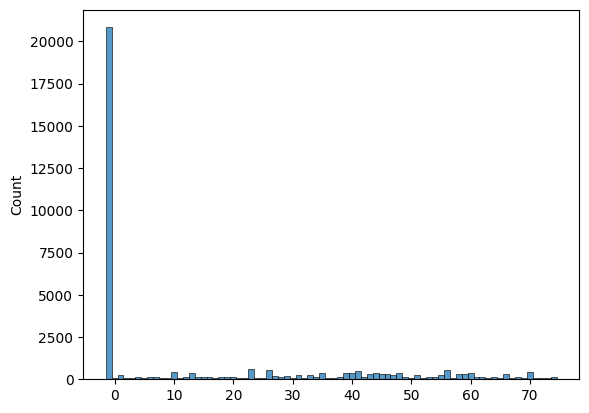

In [87]:
sns.histplot(data=labels, discrete=True)

In [88]:
calinski_harabasz_score(X_um,labels)

386.2723388671875

In [90]:
def objective(trial): 
    o_min_cluster_size = trial.suggest_int("hdb_min_cluster_size", 5, 300)
    o_min_samples = trial.suggest_int("hdb_min_samples", 1, max(1, min(50, o_min_cluster_size)))
    o_cluster_selection_method = trial.suggest_categorical("hdb_cluster_selection_method", ["eom", "leaf"])
    o_cluster_selection_epsilon= trial.suggest_float("hdb_cluster_selection_epsilon", 0.0, 0.2)
    model = HDBSCAN( 
        min_cluster_size= o_min_cluster_size, 
        min_samples = o_min_samples, 
        metric = 'euclidean', 
        cluster_selection_method = o_cluster_selection_method, 
        cluster_selection_epsilon = o_cluster_selection_epsilon 
        ) 
    model.fit(tags_umapped) 
    return calinski_harabasz_score(tags_umapped, model.labels_)

In [91]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))

[I 2025-11-13 23:00:46,500] A new study created in memory with name: no-name-734d58a2-5545-411c-b915-1e1a1ffd04d9


In [92]:
study.optimize(objective, n_trials=80, n_jobs=1)

[I 2025-11-13 23:00:54,285] Trial 0 finished with value: 1087.337646484375 and parameters: {'hdb_min_cluster_size': 115, 'hdb_min_samples': 48, 'hdb_cluster_selection_method': 'eom', 'hdb_cluster_selection_epsilon': 0.031203728088487304}. Best is trial 0 with value: 1087.337646484375.
[I 2025-11-13 23:00:57,770] Trial 1 finished with value: 1351.08544921875 and parameters: {'hdb_min_cluster_size': 51, 'hdb_min_samples': 3, 'hdb_cluster_selection_method': 'eom', 'hdb_cluster_selection_epsilon': 0.1416145155592091}. Best is trial 1 with value: 1351.08544921875.
[I 2025-11-13 23:01:01,259] Trial 2 finished with value: 118.84757995605469 and parameters: {'hdb_min_cluster_size': 11, 'hdb_min_samples': 11, 'hdb_cluster_selection_method': 'eom', 'hdb_cluster_selection_epsilon': 0.03636499344142013}. Best is trial 1 with value: 1351.08544921875.
[I 2025-11-13 23:01:04,672] Trial 3 finished with value: 622.6228637695312 and parameters: {'hdb_min_cluster_size': 59, 'hdb_min_samples': 16, 'hdb_cl

In [93]:
study.best_params, study.best_value

({'hdb_min_cluster_size': 223,
  'hdb_min_samples': 1,
  'hdb_cluster_selection_method': 'leaf',
  'hdb_cluster_selection_epsilon': 0.18230938216768253},
 3717.68896484375)

In [ ]:
model = HDBSCAN( 
        min_cluster_size= 223, 
        min_samples = 1, 
        metric = 'euclidean', 
        cluster_selection_method = 'leaf', 
        cluster_selection_epsilon = 0.18230938216768253 
        ) 
labels = model.fit(tags_umapped) 

<Axes: ylabel='Count'>

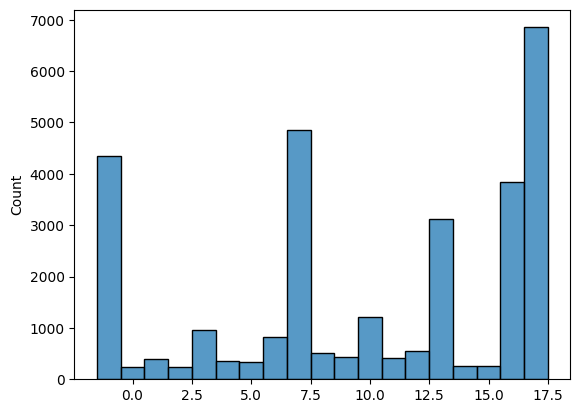

In [96]:
sns.histplot(data=model.labels_, discrete=True)

In [ ]:
pca = PCA(n_components=1024, svd_solver='randomized')
X_pca = pca.fit_transform(questions_normalized)
um = UMAP(n_components=5, n_neighbors=15, min_dist=0.0, metric='cosine', random_state=42)
tags_umapped = um.fit_transform(X_pca)